# Deep Learning (AI5100): Assignment-3
### Topic: Self Attention in computer vision
### Roll Number: CS23MTECH14003
### Name: Hrishikesh Hemke

1. Self-Attention for Object Recognition with CNNs: Implement a sample CNN with one or
more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to
implement the self-attention layer yourself and use it in the forward function defined by you. All
other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The
network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and
1x GAP). Please refer to the reading material provided here or any other similar one.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as trans
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Define transformations
transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full CIFAR-10 dataset
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 25
# Create DataLoaders for the full datasets
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
full_test_loader = torch.utils.data.DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False)

# Verify class counts in the full datasets
class_counts_train = {class_label: 0 for class_label in range(10)}
class_counts_test = {class_label: 0 for class_label in range(10)}
for _, target in full_train_dataset:
    class_counts_train[target] += 1
for _, target in full_test_dataset:
    class_counts_test[target] += 1

print("Class counts in full training dataset:")
for class_label, count in class_counts_train.items():
    print(f"Class {class_label}: {count} samples")

print("\nClass counts in full testing dataset:")
for class_label, count in class_counts_test.items():
    print(f"Class {class_label}: {count} samples")

100%|██████████| 170498071/170498071 [00:01<00:00, 94727665.03it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Class counts in full training dataset:
Class 0: 5000 samples
Class 1: 5000 samples
Class 2: 5000 samples
Class 3: 5000 samples
Class 4: 5000 samples
Class 5: 5000 samples
Class 6: 5000 samples
Class 7: 5000 samples
Class 8: 5000 samples
Class 9: 5000 samples

Class counts in full testing dataset:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


In [3]:
# Define a function to display one image from each class
def show_one_image_per_class(dataset):
    # Create a dictionary to store the index of the first occurrence of each class
    class_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = idx

    # Set up a figure to display the images
    num_classes = len(class_indices)
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 2))

    # Retrieve and display one image from each class
    for i, (class_label, idx) in enumerate(class_indices.items()):
        image, _ = dataset[idx]
        image = image.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        image = (image + 1) / 2  # Unnormalize
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_label}')
        axes[i].axis('off')
    plt.show()   

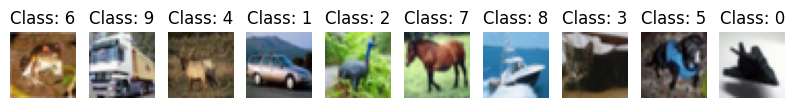

In [4]:
# Display one image from each class in full_train_dataset
show_one_image_per_class(full_train_dataset)

In [5]:
# Define the self-attention layer
class Self_Atten_Layer(nn.Module):
    def __init__(self, in_channels, k=8):
        super(Self_Atten_Layer, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//k, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//k, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        proj_query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1) # B x (N) x C
        proj_key = self.key_conv(x).view(batch_size, -1, width*height) # B x C x (N)
        Batch_mat_mat_product = torch.bmm(proj_query, proj_key) # batch matrix-matrix product

        attention = F.softmax(Batch_mat_mat_product, dim=-1) # softmax to get attention weights
        proj_value = self.value_conv(x).view(batch_size, -1, width*height) # B x C x (N)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # batch matrix-matrix product

        out = out.view(batch_size, channels,height,width) # B x C x W x H
        out = self.gamma * out + x
        return out

# Define the CNN architecture with self-attention
class CNN_Self_Atten_Layer(nn.Module):
    def __init__(self):
        super(CNN_Self_Atten_Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.sa1 = Self_Atten_Layer(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1)
        self.sa2 = Self_Atten_Layer(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1,padding=1)
        self.sa3 = Self_Atten_Layer(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1,padding=1)
        self.sa4 = Self_Atten_Layer(512)
        self.conv5 = nn.Conv2d(512, 10, kernel_size=3, stride=1,padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.sa1(x)
        x = F.relu(self.conv2(x))
        x = self.sa2(x)
        x = F.relu(self.conv3(x))
        x = self.sa3(x)
        x = F.relu(self.conv4(x))
        x = self.sa4(x)
        x = self.conv5(x)
        x = self.global_avg_pool(x)
        x = x.view(-1, 10)
        return x

In [6]:
# Model, loss function, optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = CNN_Self_Atten_Layer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device

device(type='cuda', index=0)

In [7]:
losses_1 = []  # Store average loss values for plotting
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    total_batches = 0
    for i, data in enumerate(full_train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1

    epoch_loss = running_loss / total_batches
    losses_1.append(epoch_loss)  # Store the average loss for the epoch

    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, 15, epoch_loss))

print('Finished Training')

Epoch [1/15], Loss: 1.6244
Epoch [2/15], Loss: 1.1711
Epoch [3/15], Loss: 0.9635
Epoch [4/15], Loss: 0.8255
Epoch [5/15], Loss: 0.7227
Epoch [6/15], Loss: 0.6410
Epoch [7/15], Loss: 0.5760
Epoch [8/15], Loss: 0.5115
Epoch [9/15], Loss: 0.4693
Epoch [10/15], Loss: 0.4253
Epoch [11/15], Loss: 0.3853
Epoch [12/15], Loss: 0.3555
Epoch [13/15], Loss: 0.3294
Epoch [14/15], Loss: 0.3031
Epoch [15/15], Loss: 0.3031
Finished Training


In [8]:
# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in full_test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        prob = F.softmax(outputs, dim=1)
        _, predicted = torch.max(prob, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 76 %


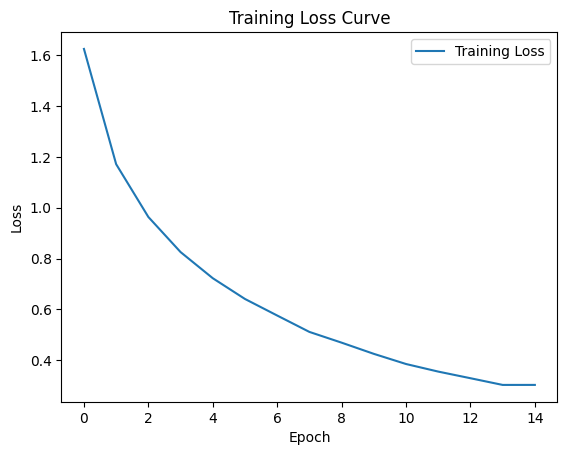

In [9]:
# Plotting the loss curve
plt.plot(losses_1, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

2. Object Recognition with Vision Transformer: Implement and train an Encoder only Transformer (ViT-like) for the above object recognition task. In other words, implement multi-headed
self-attention for the image classification (i.e., appending a < class > token to the image patches
that are accepted as input tokens). Compare the performance of the two implementations (try to
keep the number of parameters to be comparable and use the same amount of training and testing
data).

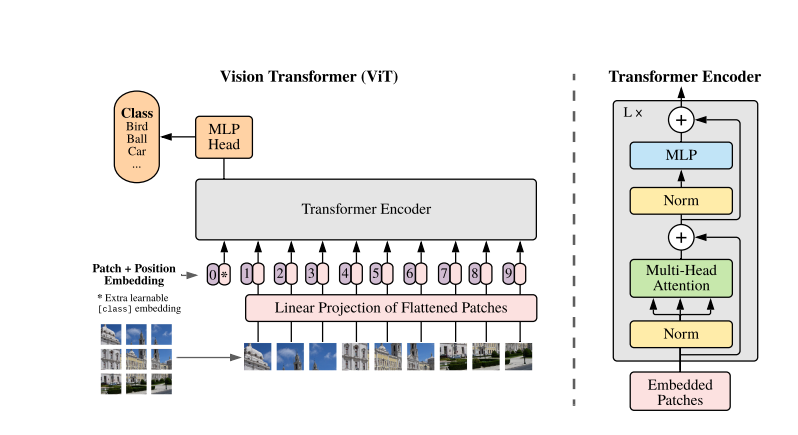

I have implemented the above architecture.

In [10]:
# Define model architecture
class Patch_Embedding(nn.Module):
    def __init__(self, inp_img_size=32, patch_size_img=4, in_chans=3, embed_dimension=64):
        super().__init__()
        self.inp_img_size = inp_img_size
        self.patch_size_img = patch_size_img
        self.num_patches = (inp_img_size // patch_size_img) ** 2
        self.projection = nn.Conv2d(in_chans, embed_dimension, kernel_size=patch_size_img, stride=patch_size_img)

    def forward(self, x):
        x = self.projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class Multi_Head_Attention(nn.Module):
    def __init__(self, embed_dimension=64, num_heads=4):
        super().__init__()
        self.embed_dimension = embed_dimension
        self.num_heads = num_heads
        self.head_dim = embed_dimension // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dimension, embed_dimension * 3)
        self.proj = nn.Linear(embed_dimension, embed_dimension)

    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        qkv = self.qkv(x)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dp = (q @ k_t) * self.scale
        attn = dp.softmax(dim=-1)
        weighted_avg = attn @ v
        weighted_avg = weighted_avg.transpose(1, 2).flatten(2)
        x = self.proj(weighted_avg)
        return x

class FeedForward(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class Transformer_Encoder_Blk(nn.Module):
    def __init__(self, embed_dimension=64, num_heads=4, mlp_ratio=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dimension)
        self.attention = Multi_Head_Attention(embed_dimension, num_heads)
        self.norm2 = nn.LayerNorm(embed_dimension)
        hidden_features = int(embed_dimension * mlp_ratio)
        self.mlp = FeedForward(embed_dimension, hidden_features, embed_dimension)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class Vision_Transformer(nn.Module):
    def __init__(self, inp_img_size=32, patch_size_img=4, in_chans=3, num_classes=10, embed_dimension=64, depth=3, num_heads=4, mlp_ratio=2):
        super().__init__()
        self.patch_embed = Patch_Embedding(inp_img_size, patch_size_img, in_chans, embed_dimension)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dimension))
        self.pos_embed = nn.Parameter(torch.randn(1, (inp_img_size // patch_size_img) ** 2 + 1, embed_dimension))
        self.pos_dropout = nn.Dropout(0.1)
        self.blocks = nn.ModuleList([Transformer_Encoder_Blk(embed_dimension, num_heads, mlp_ratio) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dimension)
        self.head = nn.Linear(embed_dimension, num_classes)

    def forward(self, x):
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(n_samples, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embed
        x = self.pos_dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x


In [11]:
# Defining Hyperparameters
batch_size = 64
learn_rate = 0.001
num_epochs = 15

In [12]:
# Create DataLoaders for the full datasets
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
full_test_loader = torch.utils.data.DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Model, loss function, optimizer
model = Vision_Transformer()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

In [14]:
# Training loop
total_step = len(full_train_loader)
losses_2 = []  # to store the losses at each epoch

for epoch in range(num_epochs):
    epoch_loss = 0.0  # to store the total loss for the epoch
    for i, (images, labels) in enumerate(full_train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  # add the loss to the epoch_loss
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")
    
    epoch_loss /= len(full_train_loader)  # average loss per batch for the epoch
    losses_2.append(epoch_loss)  # store the average loss for the epoch
    
    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

Epoch [1/15], Step [100/782], Loss: 2.1692
Epoch [1/15], Step [200/782], Loss: 2.0625
Epoch [1/15], Step [300/782], Loss: 1.8787
Epoch [1/15], Step [400/782], Loss: 1.5486
Epoch [1/15], Step [500/782], Loss: 1.7394
Epoch [1/15], Step [600/782], Loss: 1.6280
Epoch [1/15], Step [700/782], Loss: 1.7825
Epoch [1/15], Average Loss: 1.7702
Epoch [2/15], Step [100/782], Loss: 1.4553
Epoch [2/15], Step [200/782], Loss: 1.5000
Epoch [2/15], Step [300/782], Loss: 1.6784
Epoch [2/15], Step [400/782], Loss: 1.5527
Epoch [2/15], Step [500/782], Loss: 1.4450
Epoch [2/15], Step [600/782], Loss: 1.3868
Epoch [2/15], Step [700/782], Loss: 1.7032
Epoch [2/15], Average Loss: 1.4986
Epoch [3/15], Step [100/782], Loss: 1.7077
Epoch [3/15], Step [200/782], Loss: 1.3696
Epoch [3/15], Step [300/782], Loss: 1.3496
Epoch [3/15], Step [400/782], Loss: 1.3269
Epoch [3/15], Step [500/782], Loss: 1.3000
Epoch [3/15], Step [600/782], Loss: 1.3167
Epoch [3/15], Step [700/782], Loss: 1.2313
Epoch [3/15], Average Loss:

In [15]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in full_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy of the model on the {total} test images: {100 * correct / total}%")

Accuracy of the model on the 10000 test images: 62.85%


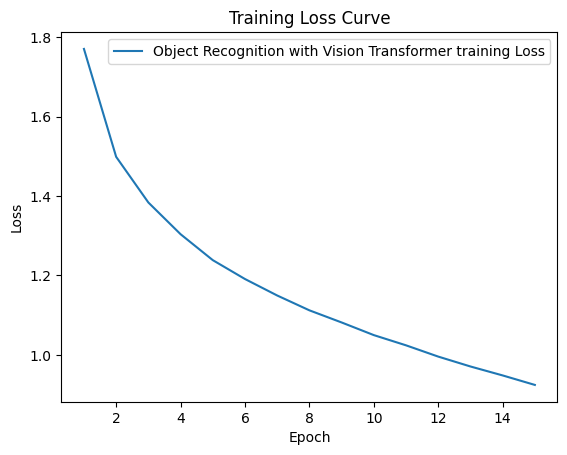

In [16]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), losses_2, label='Object Recognition with Vision Transformer training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

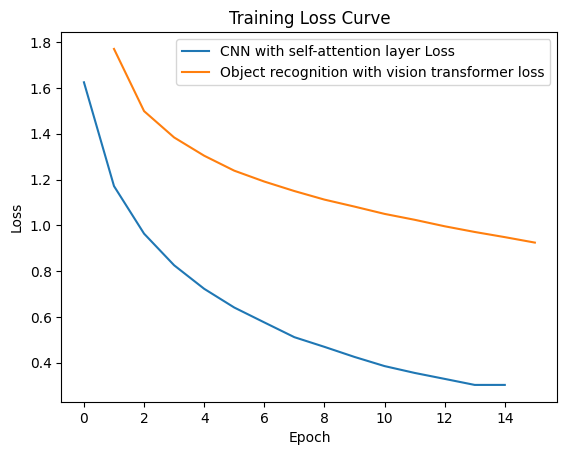

In [17]:
# Plotting the loss curves together
plt.plot(losses_1, label='CNN with self-attention layer Loss ')  # Plot losses_1 for epoch-wise loss
plt.plot(range(1, num_epochs+1), losses_2, label='Object recognition with vision transformer loss')  # Plot losses_2 for epoch-wise loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

### Obervations which I have found are:

##### 1) Training loss decreases much faster in case of the CNN with self-attention as compared to the training loass of the Object Recognition with Vision Transformer loss.

##### 2) Training time in case of CNN with self-attention is much higher than Object Recognition with Vision Transformer because of the number of computation and matrix multiplication  

